<a href="https://colab.research.google.com/github/maryamhashemi/Persian_VQA/blob/master/persian_VQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Prerequesties

In [33]:
! pip install arabic_reshaper 
! pip install python-bidi

In [0]:
import os
import re
import json
from PIL import Image 
import arabic_reshaper
from collections import Counter
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Multiply

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Set Parameters

In [0]:
DROPOUT_RATE = 0.5
EMBEDDING_DIM = 300
EPOCHS = 10
BATCH_SIZE = 256

BASE_PATH = '/content/drive/My Drive/Persian_VQA/'
QUESTION_TRAIN_PATH =   os.path.join(BASE_PATH, 'google-train_questions.json')
ANNOTATION_TRAIN_PATH = os.path.join(BASE_PATH, 'google-train-annotations.json')
IMAGE_TRAIN_PATH = os.path.join(BASE_PATH, 'train_images_1000')

QUESTION_VAL_PATH =   os.path.join(BASE_PATH, '...')
ANNOTATION_VAL_PATH = os.path.join(BASE_PATH, '...')
IMAGE_VAL_PATH = os.path.join(BASE_PATH, '...')

QUESTION_TEST_PATH =   os.path.join(BASE_PATH, '...')
ANNOTATION_TEST_PATH = os.path.join(BASE_PATH, '...')
IMAGE_TEST_PATH = os.path.join(BASE_PATH, '...')

### Read Data

In [0]:
def read_image_paths(dir_path):
  ims = {}

  for filename in os.listdir(dir_path):
    if filename.endswith('.jpg'):
      image_id = int(re.findall('\d+', filename)[1])
      ims[image_id] = os.path.join(dir_path, filename)

  return ims

In [0]:
def load_and_proccess_image(image_path):
  base_model = VGG16(weights='imagenet', include_top=False)
  model = Model(inputs=base_model.input, outputs=base_model.get_layer('...').output)

  im = load_img(image_path, target_size=(...,...))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  features = model.predict(x)

  return features

In [0]:
def read_images(paths):
  ims = {}
  for image_id, image_path in paths.items():
    ims[image_id] = load_and_proccess_image(image_path)
  return ims

In [0]:
def get_train_image_paths():
  return read_image_paths(IMAGE_TRAIN_PATH)

In [0]:
def get_test_image_paths():
  return read_image_paths(IMAGE_TEST_PATH)

In [0]:
def create_dataset(ims, qus, ann):
  qs = []
  answers = []
  qs_id = []
  im_id = []

  for q in qus['questions']:
    if q['image_id'] in ims.keys():
      qs.append(q['question'])
      qs_id.append(q['question_id'])
      im_id.append(q['image_id'])

  for ann in ann['annotations']:
    if ann['question_id'] in qs_id:
      answer_counts = Counter(a['answer'] for a in ann['answers'])
      answers.append(answer_counts.most_common(1)[0][0])

  return qs, answers, qs_id, im_id

In [0]:
def get_train_dataset():
  ims = get_train_image_paths()
  qs = json.load( open(QUESTION_TRAIN_PATH))
  ann = json.load( open(ANNOTATION_TRAIN_PATH))
  
  return create_dataset(ims, qs, ann)

In [0]:
def get_test_dataset():
  ims = get_test_image_paths()
  qs = json.load( open(QUESTION_TEST_PATH))
  ann = json.load( open(ANNOTATION_TEST_PATH))
  
  return create_dataset(ims, qs, ann)

In [0]:
def show_visualqa(qs, answer, image):
  im = Image.open(image)  
  plt.figure()
  plt.imshow(im)
  title = arabic_reshaper.reshape(qs + "\n" + answer)
  title = get_display(title) 
  plt.title(title)
  plt.show()

def visualize_train(num):
  show_visualqa(train_qs[num], train_answers[num], ims.get(train_image_ids[num]))

In [42]:
train_qs, train_answers, train_q_ids, train_image_ids = get_train_dataset()
# test_qs, test_answers, test_q_ids, test_image_ids = get_test_dataset()

print(len(train_qs))
print(len(train_answers))
print(len(train_q_ids))
print(len(train_image_ids))

3000
3000
3000
3000


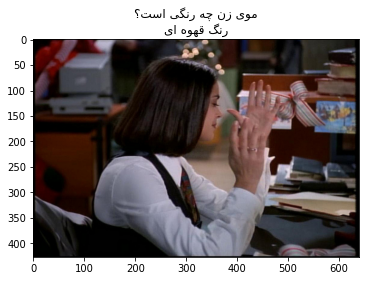

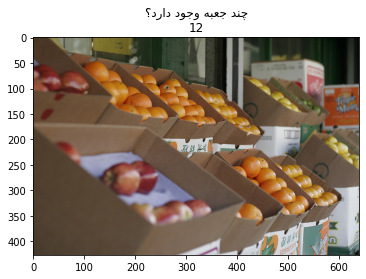

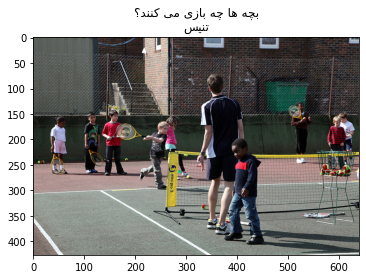

In [60]:
ims = get_train_image_paths()
visualize_train(1100)
visualize_train(2200)
visualize_train(600)

In [0]:
def get_labels(answers):
  return label

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_qs)

train_X_seqs = tokenizer.texts_to_matrix(train_qs)
# test_X_seqs = tokenizer.texts_to_matrix(test_qs)

train_ims = read_images(get_train_image_paths())
#test_ims = read_images(get_test_image_paths())

train_X_ims = [train_ims[id] for id in train_image_ids]
# test_X_ims = [test_ims[id] for id in test_image_ids]

train_Y = ...
test_Y = ...

train_X_seqs = np.array(train_X_seqs)
# test_X_seqs = np.array(test_X_seqs)

train_X_ims = np.array(train_X_ims)
# test_X_ims = np.array(test_X_ims)

### Build Vanilla Network

In [0]:
def img_model(img_input):
  x = Dense(1024, activation='tanh', input_dim = 4096)(img_input)

  return model


In [0]:
def qs_model(qs_input, num_words, embedding_dim, dropout_rate):

  x = Embedding(num_words, embedding_dim)(qs_input)
  x = LSTM(units=512, return_sequences=True, input_shape= (None,embedding_dim))(x)
  x = Dropout(dropout_rate)(x)
  x = LSTM(units=512, return_sequences=False)(x)
  x = Dropout(dropout_rate)(x)
  x = Dense(1024, activation='tanh')(x)

  return x

In [0]:
def vanilla(num_classes, dropout_rate, num_words, embedding_dim):
  qs_input = Input(input_shape=())
  img_input = Inpute(input_shape=())

  CNN_model = img_model(img_input)
  LSTM_model = qs_model(qs_input, num_words, embedding_dim, dropout_rate)

  x = Multiply([CNN_model, LSTM_model])
  x = Dropout(dropout_rate)(x)
  x = Dense(1000, activation='tanh')(x)
  x = Dropout(dropout_rate)(x)
  output = Dense(num_classes, activation='softmax')(x)
  
  model = Model(inputs= [qs_input, img_input], outputs= output)
  return model

### Train

In [0]:
def Train():
  num_classes = ...
  num_words = ...
  checkpointer = ModelCheckpoint(...)

  model = vanilla(num_classes, DROPOUT_RATE, num_words, EMBEDDING_DIM)
  model.comile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  modle.fit(x_train,y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, callbacks = [checkpointer])


### Evaluate

In [0]:
def Evaluation():
  return true